In [1]:
# import all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")

# also import these "new" libraries 
# Note: you may have to download an add them to your environment (using e.g. 'conda install -c conda-forge folium')

import folium
from folium import plugins
from folium.plugins import HeatMap
from datetime import datetime
from datetime import timedelta
import math
import random
import timeit

In [2]:
# first we figure out the timeframe of our data entries
marburg = pd.read_csv("../data/marburg.csv")
duisburg = pd.read_csv("../data/duisburg.csv")

In [39]:
marburg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164205 entries, 0 to 164204
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day            164205 non-null  object 
 1   time           164205 non-null  object 
 2   b_number       164205 non-null  int64  
 3   city           164205 non-null  object 
 4   trip_duration  164205 non-null  object 
 5   orig_lat       164205 non-null  float64
 6   orig_lng       164205 non-null  float64
 7   dest_lat       164205 non-null  float64
 8   dest_lng       164205 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 11.3+ MB


In [40]:
print("Marburg:")
print("first date: ", marburg['day'].min())
print("last date: ", marburg['day'].max())
print("")
print("Duisburg")
print("first date: ", duisburg['day'].min())
print("last date: ", duisburg['day'].max())

Marburg:
first date:  2019-01-20
last date:  2020-01-20

Duisburg
first date:  2019-01-20
last date:  2020-01-20


In [41]:
# then we figure out the location radius of our data entries

marburg_lat = pd.concat([marburg["orig_lat"], marburg["dest_lat"]], ignore_index=True)

In [47]:
print("Marburg: ")
print("min latitude: ", marburg_lat.min())
print("max latitude: ", marburg_lat.max())

Marburg: 
min latitude:  -504.153076
max latitude:  8084778.533


In [53]:
marburg["coordinates"] = list(zip(marburg["orig_lat"].round(4), marburg["orig_lng"].round(4)))

marburg_map_points = folium.Map(location=(50.80,8.765), tiles="Stamen Toner", zoom_start=9, control_scale=True, max_zoom=20)

positions = list(marburg["coordinates"].unique())

for position in positions:
    folium.CircleMarker(radius=5, location=position, popup="hello", color="crimson", fill_color="crimson").add_to(marburg_map_points)

marburg_map_points

In [100]:
marburg_precipitation = pd.read_csv("../data/marburg_precipitation.csv")
marburg_temperature = pd.read_csv("../data/marburg_temperature.csv")

In [101]:
marburg_temperature.set_index(marburg_temperature["Zeitstempel"], inplace=True)
marburg_precipitation.set_index(marburg_precipitation["Zeitstempel"], inplace=True)

In [102]:
marburg_precipitation.head()

Produkt_Code  SDO_ID   Zeitstempel  Wert  Qualitaet_Niveau  \
Zeitstempel                                                               
201901200000     R1_MN008    3164  201901200000   0.0                 0   
201901200100     R1_MN008    3164  201901200100   0.0                 0   
201901200200     R1_MN008    3164  201901200200   0.0                 0   
201901200300     R1_MN008    3164  201901200300   0.0                 0   
201901200400     R1_MN008    3164  201901200400   0.0                 0   

              Qualitaet_Byte  
Zeitstempel                   
201901200000               3  
201901200100               3  
201901200200               3  
201901200300               3  
201901200400               3

In [103]:
marburg_precipitation.drop("Produkt_Code", axis=1, inplace=True)
marburg_precipitation.drop("SDO_ID", axis=1, inplace=True)
marburg_precipitation.drop("Zeitstempel", axis=1, inplace=True)
marburg_precipitation.drop("Qualitaet_Niveau", axis=1, inplace=True)
marburg_precipitation.drop("Qualitaet_Byte", axis=1, inplace=True)
marburg_precipitation.rename(columns={'Wert':'precipitation'}, inplace=True)
marburg_precipitation.index.rename("timestamp", inplace=True)

In [104]:
marburg_temperature.drop("Produkt_Code", axis=1, inplace=True)
marburg_temperature.drop("SDO_ID", axis=1, inplace=True)
marburg_temperature.drop("Zeitstempel", axis=1, inplace=True)
marburg_temperature.drop("Qualitaet_Niveau", axis=1, inplace=True)
marburg_temperature.drop("Qualitaet_Byte", axis=1, inplace=True)
marburg_temperature.rename(columns={'Wert':'temperature'}, inplace=True)
marburg_temperature.index.rename("timestamp", inplace=True)

In [106]:

marburg_temperature.head()

temperature
timestamp                
201901200000         -7.9
201901200100         -8.3
201901200200         -8.7
201901200300         -8.9
201901200400         -8.7

In [114]:
marburg_weather = pd.merge(marburg_temperature, marburg_precipitation, how='outer', left_index=True, right_index=True)

In [115]:
marburg_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8784 entries, 201901200000 to 202001202300
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   temperature    8124 non-null   float64
 1   precipitation  8784 non-null   float64
dtypes: float64(2)
memory usage: 205.9 KB


In [141]:
def get_date(timestamp):
    return timestamp.date()


marburg_weather["datetime"] = pd.to_datetime(marburg_weather.index, format="%Y%m%d%H%M")
marburg_weather["date"] = marburg_weather["datetime"].map(get_date)

marburg_weather.set_index(marburg_weather["datetime"], inplace=True)
marburg_weather["temperature_interpol"] = marburg_weather["temperature"].interpolate(method="time")

In [143]:
marburg_weather[marburg_weather["temperature"].isnull() == True].head(50)

temperature  precipitation            datetime  \
datetime                                                              
2019-07-19 01:00:00          NaN            1.4 2019-07-19 01:00:00   
2019-07-19 02:00:00          NaN            0.3 2019-07-19 02:00:00   
2019-07-19 03:00:00          NaN            0.0 2019-07-19 03:00:00   
2019-07-19 04:00:00          NaN            0.2 2019-07-19 04:00:00   
2019-07-19 05:00:00          NaN            0.1 2019-07-19 05:00:00   
2019-07-19 06:00:00          NaN            0.2 2019-07-19 06:00:00   
2019-07-19 07:00:00          NaN            0.0 2019-07-19 07:00:00   
2019-07-19 08:00:00          NaN            0.0 2019-07-19 08:00:00   
2019-07-19 09:00:00          NaN            0.0 2019-07-19 09:00:00   
2019-07-19 10:00:00          NaN            0.0 2019-07-19 10:00:00   
2019-07-19 11:00:00          NaN            0.0 2019-07-19 11:00:00   
2019-07-19 12:00:00          NaN            0.0 2019-07-19 12:00:00   
2019-07-19 13:00:00          NaN            0.0 2019-07-19 13:00:00   
2019-07-19 14:00:00          NaN            0.0 2019-07-19 14:00:00   
2019-07-19 15:00:00          NaN            0.0 2019-07-19 15:00:00   
2019-07-19 16:00:00          NaN            0.0 2019-07-19 16:00:00   
2019-07-19 17:00:00          NaN            0.0 2019-07-19 17:00:00   
2019-07-20 00:00:00          NaN            0.0 2019-07-20 00:00:00   
2019-07-20 01:00:00          NaN            0.0 2019-07-20 01:00:00   
2019-07-20 02:00:00          NaN            0.0 2019-07-20 02:00:00   
2019-07-20 03:00:00          NaN            0.0 2019-07-20 03:00:00   
2019-07-20 04:00:00          NaN            0.0 2019-07-20 04:00:00   
2019-07-20 05:00:00          NaN            0.0 2019-07-20 05:00:00   
2019-07-21 00:00:00          NaN            0.1 2019-07-21 00:00:00   
2019-07-21 01:00:00          NaN            0.0 2019-07-21 01:00:00   
2019-07-21 02:00:00          NaN            0.0 2019-07-21 02:00:00   
2019-07-21 03:00:00          NaN            0.0 2019-07-21 03:00:00   
2019-07-21 04:00:00          NaN            0.0 2019-07-21 04:00:00   
2019-07-21 05:00:00          NaN            0.0 2019-07-21 05:00:00   
2019-07-21 06:00:00          NaN            0.0 2019-07-21 06:00:00   
2019-07-21 07:00:00          NaN            0.0 2019-07-21 07:00:00   
2019-07-21 08:00:00          NaN            0.0 2019-07-21 08:00:00   
2019-07-21 09:00:00          NaN            0.0 2019-07-21 09:00:00   
2019-07-21 10:00:00          NaN            0.0 2019-07-21 10:00:00   
2019-07-21 11:00:00          NaN            0.0 2019-07-21 11:00:00   
2019-07-22 00:00:00          NaN            0.0 2019-07-22 00:00:00   
2019-07-22 01:00:00          NaN            0.0 2019-07-22 01:00:00   
2019-07-22 02:00:00          NaN            0.0 2019-07-22 02:00:00   
2019-07-22 03:00:00          NaN            0.0 2019-07-22 03:00:00   
2019-07-22 04:00:00          NaN            0.0 2019-07-22 04:00:00   
2019-07-22 05:00:00          NaN            0.0 2019-07-22 05:00:00   
2019-07-23 00:00:00          NaN            0.0 2019-07-23 00:00:00   
2019-07-23 01:00:00          NaN            0.0 2019-07-23 01:00:00   
2019-07-23 02:00:00          NaN            0.0 2019-07-23 02:00:00   
2019-07-23 03:00:00          NaN            0.0 2019-07-23 03:00:00   
2019-07-23 04:00:00          NaN            0.0 2019-07-23 04:00:00   
2019-07-23 05:00:00          NaN            0.0 2019-07-23 05:00:00   
2019-07-23 06:00:00          NaN            0.0 2019-07-23 06:00:00   
2019-07-23 07:00:00          NaN            0.0 2019-07-23 07:00:00   
2019-07-23 08:00:00          NaN            0.0 2019-07-23 08:00:00   

                           date  temperature_interpol  
datetime                                               
2019-07-19 01:00:00  2019-07-19             17.422222  
2019-07-19 02:00:00  2019-07-19             17.844444  
2019-07-19 03:00:00  2019-07-19             18.266667  
2019-07-19 04:00:00  2019-07-19             18.6

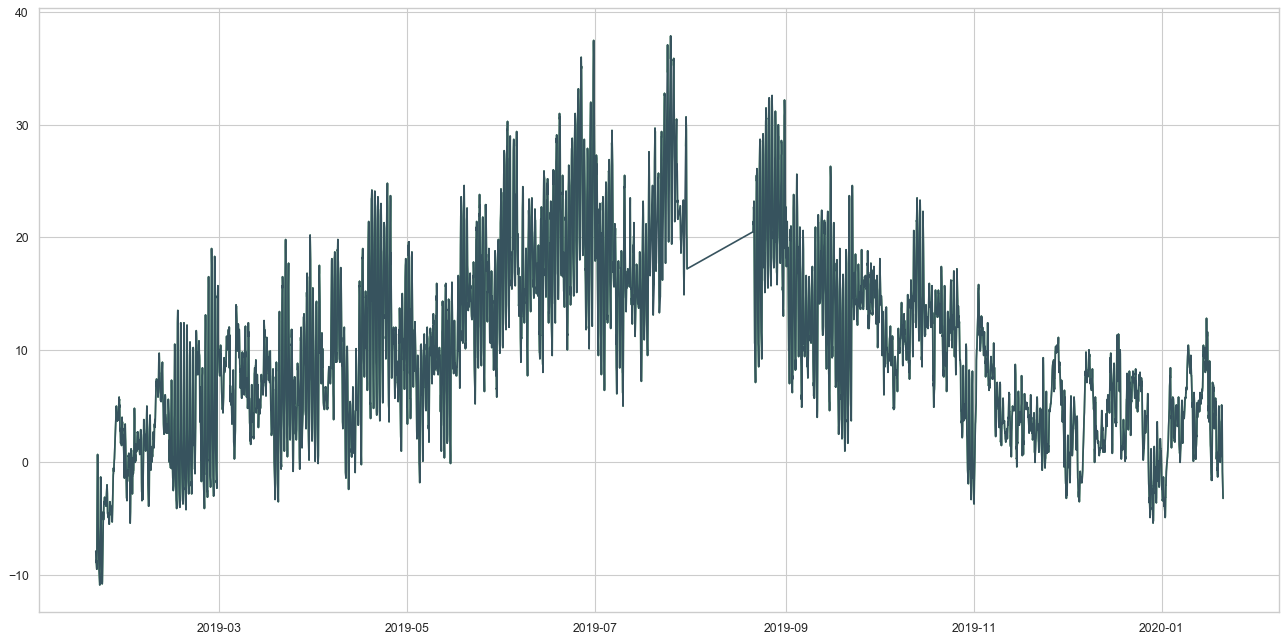

In [149]:
fix,ax = plt.subplots(figsize=(20,10), dpi=80)

ax.plot(marburg_weather["datetime"], marburg_weather["temperature"], "g",marburg_weather["datetime"] , marburg_weather["temperature_interpol"])
plt.savefig("fig.pdf")
plt.show()


In [150]:
marburg_weather

temperature  precipitation            datetime  \
datetime                                                              
2019-01-20 00:00:00         -7.9            0.0 2019-01-20 00:00:00   
2019-01-20 01:00:00         -8.3            0.0 2019-01-20 01:00:00   
2019-01-20 02:00:00         -8.7            0.0 2019-01-20 02:00:00   
2019-01-20 03:00:00         -8.9            0.0 2019-01-20 03:00:00   
2019-01-20 04:00:00         -8.7            0.0 2019-01-20 04:00:00   
...                          ...            ...                 ...   
2020-01-20 19:00:00         -1.5            0.0 2020-01-20 19:00:00   
2020-01-20 20:00:00         -1.7            0.0 2020-01-20 20:00:00   
2020-01-20 21:00:00         -2.3            0.0 2020-01-20 21:00:00   
2020-01-20 22:00:00         -2.7            0.0 2020-01-20 22:00:00   
2020-01-20 23:00:00         -3.2            0.0 2020-01-20 23:00:00   

                           date  temperature_interpol  
datetime                                               
2019-01-20 00:00:00  2019-01-20                  -7.9  
2019-01-20 01:00:00  2019-01-20                  -8.3  
2019-01-20 02:00:00  2019-01-20                  -8.7  
2019-01-20 03:00:00  2019-01-20                  -8.9  
2019-01-20 04:00:00  2019-01-20                  -8.7  
...                         ...                   ...  
2020-01-20 19:00:00  2020-01-20                  -1.5  
2020-01-20 20:00:00  2020-01-20                  -1.7  
2020-01-20 21:00:00  2020-01-20                  -2.3  
2020-01-20 22:00:00  2020-01-20                  -2.7  
2020-01-20 23:00:00  2020-01-20                  -3.2  

[8784 rows x 5 columns]